# Light GBM modeling

This version has improvements based on new feature engg techniques observed from different kernels. Below are few of them:
- https://www.kaggle.com/graf10a/lightgbm-lb-0-9675
- https://www.kaggle.com/rteja1113/lightgbm-with-count-features?scriptVersionId=2815638
- https://www.kaggle.com/nuhsikander/lgbm-new-features-corrected?scriptVersionId=2852561
- https://www.kaggle.com/aloisiodn/lgbm-starter-early-stopping-0-9539 (Original script)
---
**ここからコピー・改変**  
https://www.kaggle.com/pranav84/lightgbm-fixing-unbalanced-data-lb-0-9680/code

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import lightgbm as lgb
import time
import gc

In [2]:
path = '../../data/'
key = 'analysis_data'
# key = 'sample'

In [3]:
def lgb_modelfit_nocv(params,
                      dtrain,
                      dvalid,
                      predictors,
                      target='target',
                      objective='binary',
                      metrics='auc',
                      feval=None,
                      early_stopping_rounds=20,
                      num_boost_round=3000,
                      verbose_eval=10,
                      categorical_features=None):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': objective,
        'metric':metrics,
        'learning_rate': 0.01,
        #'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 4,
        'verbose': 0,
        'metric':metrics
    }

    lgb_params.update(params)

    print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )

    evals_results = {}

    bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[xgtrain, xgvalid], 
                     valid_names=['train','valid'], 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=10, 
                     feval=feval)

    n_estimators = bst1.best_iteration
    print("\nModel Report")
    print("n_estimators : ", n_estimators)
    print(metrics+":", evals_results['valid'][metrics][n_estimators-1])

    return bst1

In [4]:
%%time
path = '../../data/'
# merge = pd.read_hdf(path + key + '.hdf', key=key)
merge = pd.read_csv(path + key + '.csv', nrows=10000000)
merge = merge[merge.click_date >= '2017-11-07 00:00:00']
merge['doy'] = pd.to_datetime(merge.click_date).dt.dayofyear
merge.drop(['ip',
            'row_number',
            'click_time_ch',
            'click_time_hour',
            'click_time_30min',
            'click_time_15min',
            'click_time_10min',
            'click_time_5min',
            'click_time_1min'], axis=1, inplace=True)
print(merge.shape)

(10000000, 24)
CPU times: user 35 s, sys: 3.55 s, total: 38.5 s
Wall time: 38.5 s


In [5]:
merge['same_ch_pre'] = merge['channel'] == merge['chan_pre']
merge['same_ch_post'] = merge['channel'] == merge['chan_post']
merge['same_app_pre'] = merge['app'] == merge['app_pre']
merge['same_app_post'] = merge['app'] == merge['app_post']

In [6]:
merge.columns

Index(['id', 'click_id', 'app', 'device', 'os', 'channel', 'is_attributed',
       'is_test', 'uq_user', 'app_pre', 'chan_pre', 'interval_pre',
       'interval_post', 'app_post', 'chan_post', 'click_date', 'click_hour',
       'cnt_1hour', 'cnt_30min', 'cnt_15min', 'cnt_10min', 'cnt_5min',
       'cnt_1min', 'doy', 'same_ch_pre', 'same_ch_post', 'same_app_pre',
       'same_app_post'],
      dtype='object')

In [7]:
merge.head()

,id,click_id,app,device,os,channel,is_attributed,is_test,uq_user,app_pre,...,cnt_30min,cnt_15min,cnt_10min,cnt_5min,cnt_1min,doy,same_ch_pre,same_ch_post,same_app_pre,same_app_post
0,132915856,NaN,18,1,13,107,0,0,2211180130001,9.0,...,2,1,1,1,1,312,False,False,False,False
1,133697186,NaN,12,1,13,259,0,0,2211180130001,18.0,...,3,3,3,1,1,312,False,False,False,False
2,133731269,NaN,3,1,13,205,0,0,2211180130001,12.0,...,3,3,3,2,2,312,False,False,False,True
3,133731124,NaN,3,1,13,280,0,0,2211180130001,3.0,...,3,3,3,2,2,312,False,False,True,False
4,134805886,NaN,21,1,13,232,0,0,2211180130001,8.0,...,7,6,6,6,6,312,False,False,False,False


In [8]:
test_df = merge[merge.is_test == 1]
train_df = merge[(merge.is_test == 0) & (merge.click_date != '2017-11-09 00:00:00')]
val_df = merge[(merge.is_test == 0) & (merge.click_date == '2017-11-09 00:00:00')]
print(test_df.shape, train_df.shape, val_df.shape)
del merge

(0, 28) (4676483, 28) (5323517, 28)


In [9]:
target = 'is_attributed'
predictors = ['device', 'os', 
              'interval_pre', 'interval_post',
              'app','app_pre', 'app_post', 'same_app_pre', 'same_app_post',
              'channel','chan_pre', 'chan_post', 'same_ch_pre', 'same_ch_post',
              'click_hour', 'cnt_1hour', 'cnt_15min', 'cnt_1min']
categorical = ['device', 'os',
               'app','app_pre', 'app_post', 'same_app_pre', 'same_app_post',
               'channel', 'chan_pre', 'chan_post', 'same_ch_pre', 'same_ch_post']
sub = pd.DataFrame()
sub['click_id'] = test_df['click_id'].astype('int')

gc.collect()

100

In [10]:
print("Training...")
start_time = time.time()

params = {
    'learning_rate': 0.15,
    #'is_unbalance': 'true', # replaced with scale_pos_weight argument
    'num_leaves': 7,  # 2^max_depth - 1
    'max_depth': 3,  # -1 means no limit
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100,  # Number of bucketed bin for feature values
    'subsample': 0.7,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'scale_pos_weight':999 # because training data is extremely unbalanced 
}
bst = lgb_modelfit_nocv(params, 
                        train_df, 
                        val_df, 
                        predictors, 
                        target, 
                        objective='binary', 
                        metrics='auc',
                        early_stopping_rounds=30, 
                        verbose_eval=True, 
                        num_boost_round=500, 
                        categorical_features=categorical)

print('[{}]: model training time'.format(time.time() - start_time))
del train_df
del val_df
gc.collect()

Training...
preparing validation datasets


/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.979383	valid's auc: 0.973467
[20]	train's auc: 0.981996	valid's auc: 0.976556
[30]	train's auc: 0.985837	valid's auc: 0.980743
[40]	train's auc: 0.986869	valid's auc: 0.981902
[50]	train's auc: 0.987916	valid's auc: 0.982787
[60]	train's auc: 0.988571	valid's auc: 0.983234
[70]	train's auc: 0.988986	valid's auc: 0.983337
[80]	train's auc: 0.989368	valid's auc: 0.983422
[90]	train's auc: 0.989661	valid's auc: 0.983432
[100]	train's auc: 0.990038	valid's auc: 0.983404
[110]	train's auc: 0.990332	valid's auc: 0.983366
[120]	train's auc: 0.990536	valid's auc: 0.983337
Early stopping, best iteration is:
[92]	train's auc: 0.989773	valid's auc: 0.983492

Model Report
n_estimators :  92
auc: 0.9834921244818243
[142.851380109787]: model training time


80

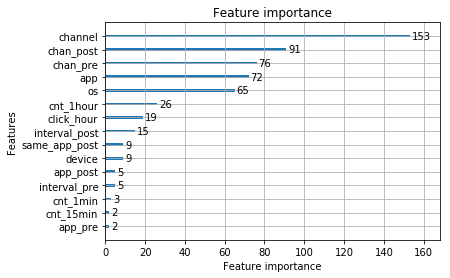

In [11]:
lgb.plot_importance(bst)

In [12]:
print("Predicting...")
sub['is_attributed'] = bst.predict(test_df[predictors])
print("writing...")
sub.to_csv('sub_lgb_balanced99.csv',index=False)
print("done...")

Predicting...
writing...
done...
